In [1]:
from utils import *

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda:1"
else:
    DEVICE = "cpu"

### Models and Reward function

In [3]:
class LSTMModel_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel_1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

        # self.sigmoid  = nn.Sigmoid()

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)

        # out = self.sigmoid(out)

        return out
    
    


In [4]:
class PointwiseLinear(torch.nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim):
        super().__init__()

        self.W1 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, input_feature_dim))
        self.W2 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, output_feature_dim * 4))
        self.W3 = torch.nn.Parameter(torch.rand(output_feature_dim, 1, output_feature_dim * 2))
        
        torch.nn.init.xavier_uniform_(self.W1)
        torch.nn.init.xavier_uniform_(self.W2)
        torch.nn.init.xavier_uniform_(self.W3)
        
        self.fc1 = torch.nn.Linear(input_feature_dim, output_feature_dim * 4)
        self.fc2 = torch.nn.Linear(output_feature_dim * 4, output_feature_dim * 2)
        self.fc3 = torch.nn.Linear(output_feature_dim * 2, output_feature_dim)
        
        
        
        self.relu = nn.ReLU()
        
        
        
    def forward(self, x):
        out = self.relu(self.W1 * x) #().mean(dim=(-2, -1))
        out = self.fc1(out)
        out = self.relu(self.W2 * out)
        out = self.fc2(out)
        out = self.relu(self.W3 * out)
        out = (self.fc3(out)).mean(dim=(0, 1))
        
        return out
    
# Without neighbors count padding
class LSTMModel_2(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(LSTMModel_2, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(
            16,
            self.hidden_size,
            self.num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )
        
        self.feature_extractor = PointwiseLinear(self.input_size, 16)
        self.fc_1 = nn.Linear(self.hidden_size + 9, self.hidden_size)
        
        #TODO: reduce the size of the dense net below
        self.fc_2 = nn.Sequential(
            nn.Linear(self.hidden_size // 1, self.hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(self.hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(self.hidden_size // 4, self.hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(self.hidden_size // 8, self.output_size),
        )


    def forward(self, x, x_target):
        
        # B x T x N x F
        
        B = len(x)
        T = len(x[0])
        
        features = []
        
        for i in range(B):
            
            time_features = []
            
            #TODO: do not loop over time axis, pad the N axis :D
            for j in range(T):
                extracted_features = self.feature_extractor(torch.from_numpy(x[i][j].astype(np.float32)).to(dtype=torch.float32, device=DEVICE))
                time_features.append(extracted_features)
            
            time_features = torch.stack(time_features, dim=0)
            features.append(time_features)
        
        features = torch.stack(features, dim=0)
        lstm_features, _ = self.lstm(features)
        lstm_features = lstm_features[:, -1, ...]
        
        x_target = torch.from_numpy(np.stack(x_target).astype(np.float32)).to(dtype=torch.float32, device=DEVICE)
        combined_features = torch.cat([lstm_features, x_target], dim=-1)
            
        
        out = self.fc_1(combined_features)
        out = self.fc_2(out)
        
        return out

In [5]:
def Reward(outputs, price):
    reward = outputs * price
    return reward

### Creating model, loading weights and data

In [6]:
model1 = LSTMModel_1(78, 512, 5, 1).to(device=DEVICE).eval()
model1.load_state_dict(
    torch.load("./models/lstm_training_04_09_2023.pth")
);

model2 =LSTMModel_2(input_size=78, hidden_size=512, num_layers=5, output_size=1).to(DEVICE).eval()
model2.load_state_dict(
    torch.load("./models/test_08_09.pth")
);

### Optimization step for neighboours and qids

#### Model 1

In [7]:
data_X = torch.split(
    torch.load("data/X_val_1000.pt")
    .permute(0, 1, 3, 2)
    .to(torch.float32),
    1,
)

data_x = torch.split(
    torch.load("data/x_val_1000.pt").to(torch.float32), 1
)

In [8]:
price_mean, price_std = (21.230517726667767, 13.387471717906585)
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in tqdm(enumerate(zip(data_X, data_x)), total=1000):
    for j, price in enumerate(np.linspace(0, 100, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        mean_b = model1(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward


100%|███████████████████████████████████████| 1000/1000 [12:59<00:00,  1.28it/s]


In [9]:
test_qids = np.load("data/val_qids_1000.npy")
test_qids.sort()

data = pd.read_pickle("./data/decade_price_data_combined_01_09.pkl")
data = data[data.GJ == 2023]
data.sort_values(by="Qid", inplace=True)

qid_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis", "Min_optimal_preis_5%_margin", "Max_optimal_preis_5%_margin"])

qid_data["Qid"] = test_qids
qid_data["Preis"] = data[data.Qid.isin(test_qids)].Preis.values

new_history = {}
new_history_plot = {}

def find_nearest(array, value, idxis=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if idxis:
        return idx
    return array[idx]
 
for k, qid in enumerate(test_qids):
    try:
        peak_ids = scipy.signal.find_peaks(history[k, 2])[0]
        prices = history[k, 0, peak_ids]
        optim_price = find_nearest(prices, data[data.Qid == qid].Preis.values)
        margin = optim_price * 0.05
        new_history[qid] = [optim_price-margin, optim_price, optim_price+margin]
        ids = find_nearest(optim_price, data[data.Qid == qid].Preis.values, True)  

        new_history_plot[qid] = peak_ids[ids]
    except:
        new_history[qid] = [np.nan, np.nan, np.nan]
        new_history_plot[qid] = 0 
        

### Plot of reward func and optimal price range

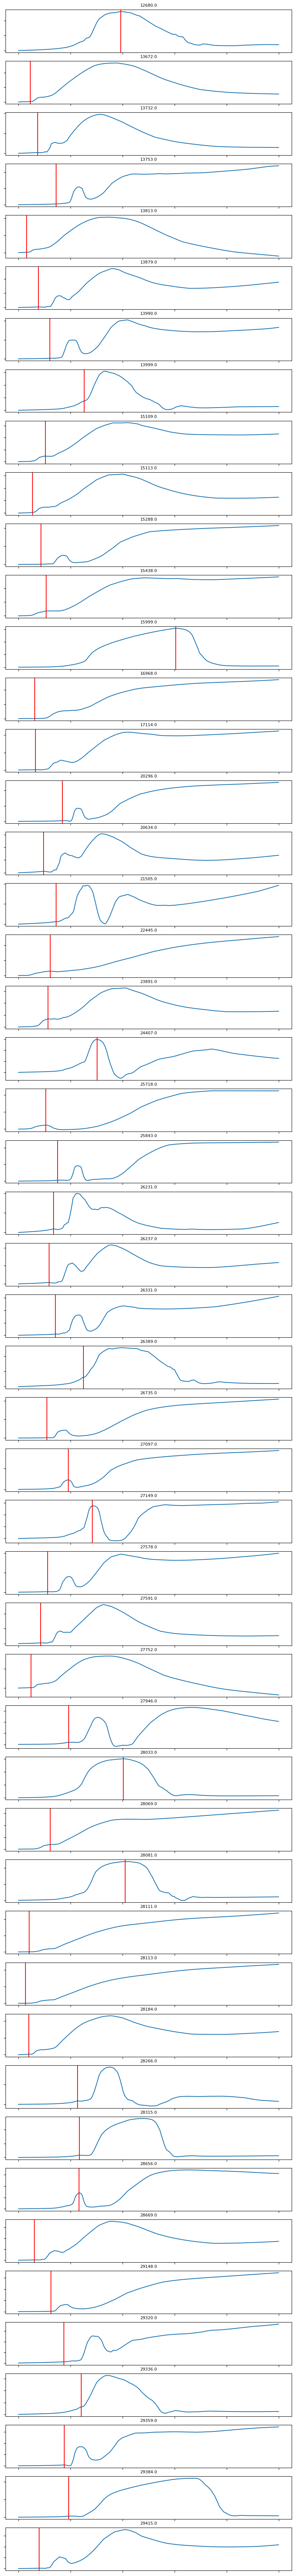

In [10]:
fig, ax = plt.subplots(history[:50].shape[0], figsize=(10, 90))
    
for j in range(history[:50].shape[0]):
    ax[j].plot(history[j, -1, :])
    if list(new_history_plot.values())[j]:
        ax[j].axvline(list(new_history_plot.values())[j], color="red")
    ax[j].set_title(list(new_history_plot.keys())[j], fontsize=8)
    ax[j].set_yticklabels([])
    ax[j].set_xticklabels([])

### Prepairing and saving optimal price with different sheets based on 4 qids

In [11]:
for j, qid in enumerate(test_qids):
    qid_data.iloc[j, 2] = new_history[qid][1]
    qid_data.iloc[j, 3] = new_history[qid][0]
    qid_data.iloc[j, 4] = new_history[qid][2]

In [12]:
qid_data

,Qid,Preis,Optimal_preis,Min_optimal_preis_5%_margin,Max_optimal_preis_5%_margin
0,12680.0,38.6,39.339339,37.372372,41.306306
1,13672.0,12.0,9.209209,8.748749,9.66967
2,13732.0,16.4,14.114114,13.408408,14.81982
3,13753.0,22.1,23.123123,21.966967,24.279279
4,13813.0,10.9,6.606607,6.276276,6.936937
...,...,...,...,...,...
995,417399.0,15.2,15.315315,14.54955,16.081081
996,417667.0,56.0,68.668669,65.235235,72.102102
997,418527.0,18.8,19.019019,18.068068,19.96997
998,420114.0,59.6,68.868869,65.425425,72.312312


In [13]:
with pd.ExcelWriter('optimal_preis_1000_model1.xlsx') as writer:
    qid_data.to_excel(writer, index=False)  

#### Model 2

In [14]:
data_X = torch.load("data/X_val_1000_model2.pt")
data_x = torch.load("data/x_val_1000_model2.pt")

In [15]:
price_mean, price_std = (21.230517726667767, 13.387471717906585)
M = len(data_X)
N = 1000
history_model2 = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in tqdm(enumerate(zip(data_X, data_x)), total=1000):
    for j, price in enumerate(np.linspace(0, 100, N)):
        
        sample_x[-5] = (price - price_mean) / price_std
        mean_b = model2([sample_X], [sample_x]).detach().cpu().numpy()[..., 0]
        reward = Reward(price, mean_b)
        history_model2[i, 0, j] = price
        history_model2[i, 1, j] = mean_b
        history_model2[i, 2, j] = reward

100%|███████████████████████████████████████| 1000/1000 [28:43<00:00,  1.72s/it]


In [16]:
test_qids = np.load("data/val_qids_1000.npy")
test_qids.sort()

data = pd.read_pickle("./data/decade_price_data_combined_01_09.pkl")
data = data[data.GJ == 2023]
data.sort_values(by="Qid", inplace=True)

qid_data_model2 = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis", "Min_optimal_preis_5%_margin", "Max_optimal_preis_5%_margin"])

qid_data_model2["Qid"] = test_qids
qid_data_model2["Preis"] = data[data.Qid.isin(test_qids)].Preis.values

new_history_model2 = {}
new_history_plot_model2 = {}

def find_nearest(array, value, idxis=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if idxis:
        return idx
    return array[idx]
 
for k, qid in enumerate(test_qids):
    try:
        peak_ids = scipy.signal.find_peaks(history_model2[k, 2])[0]
        prices = history_model2[k, 0, peak_ids]
        optim_price = find_nearest(prices, data[data.Qid == qid].Preis.values)
        margin = optim_price * 0.05
        new_history_model2[qid] = [optim_price-margin, optim_price, optim_price+margin]
        ids = find_nearest(optim_price, data[data.Qid == qid].Preis.values, True)  

        new_history_plot_model2[qid] = peak_ids[ids]
    except:
        new_history_model2[qid] = [np.nan, np.nan, np.nan]
        new_history_plot_model2[qid] = 0 
        

### Plot of reward func and optimal price range

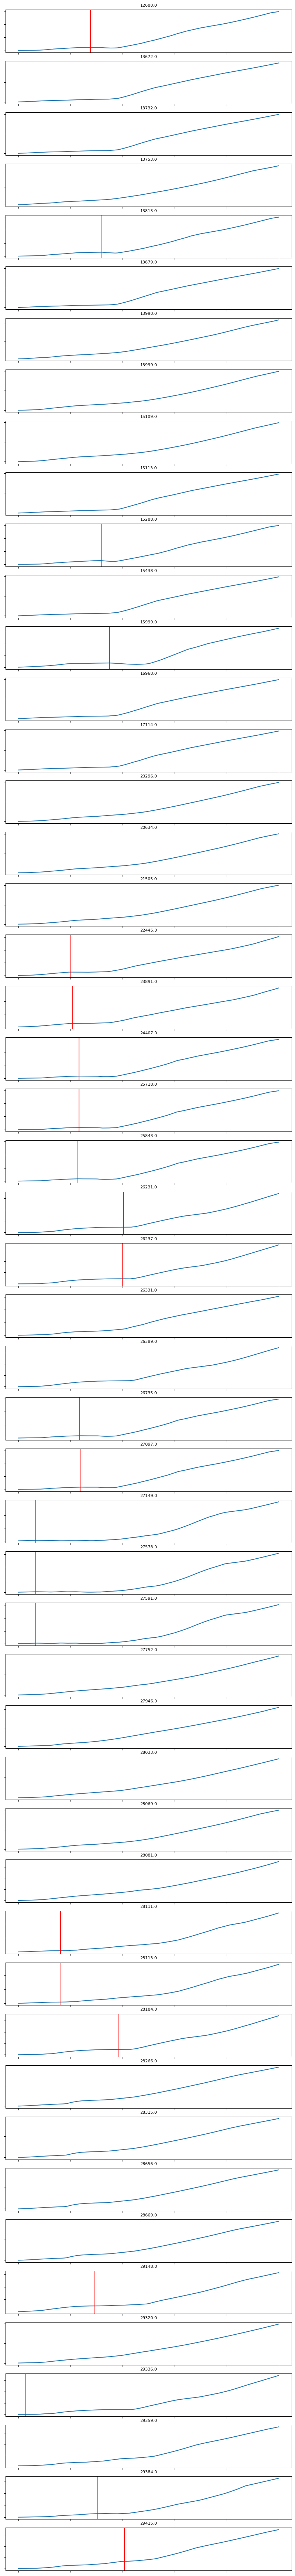

In [17]:
fig, ax = plt.subplots(history_model2[:50].shape[0], figsize=(10, 90))
    
for j in range(history_model2[:50].shape[0]):
    ax[j].plot(history_model2[j, -1, :])
    if list(new_history_plot_model2.values())[j]:
        ax[j].axvline(list(new_history_plot_model2.values())[j], color="red")
    ax[j].set_title(list(new_history_plot_model2.keys())[j], fontsize=8)
    ax[j].set_yticklabels([])
    ax[j].set_xticklabels([])

### Plot of reward func and optimal price range

In [18]:
for j, qid in enumerate(test_qids):
    qid_data_model2.iloc[j, 2] = new_history_model2[qid][1]
    qid_data_model2.iloc[j, 3] = new_history_model2[qid][0]
    qid_data_model2.iloc[j, 4] = new_history_model2[qid][2]

In [19]:
qid_data_model2

,Qid,Preis,Optimal_preis,Min_optimal_preis_5%_margin,Max_optimal_preis_5%_margin
0,12680.0,38.6,31.431431,29.85986,33.003003
1,13672.0,12.0,NaN,NaN,NaN
2,13732.0,16.4,NaN,NaN,NaN
3,13753.0,22.1,NaN,NaN,NaN
4,13813.0,10.9,32.132132,30.525526,33.738739
...,...,...,...,...,...
995,417399.0,15.2,NaN,NaN,NaN
996,417667.0,56.0,33.533534,31.856857,35.21021
997,418527.0,18.8,1.601602,1.521522,1.681682
998,420114.0,59.6,41.641642,39.55956,43.723724


In [20]:
with pd.ExcelWriter('optimal_preis_1000_model2.xlsx') as writer:
    qid_data.to_excel(writer, index=False)  